# Отток клиентов банка

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.simplefilter("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

rnd_state = 702

# 1. Подготовка данных

Загрузим и изучим данные.

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
print('Geography:', data.Geography.unique())
print('Genders:', data.Gender.unique())

Geography: ['France' 'Spain' 'Germany']
Genders: ['Female' 'Male']


1. Мы видим 909 пропусков в столбце `Tenure (количество недвижимости)`. Предположим, что эти пропуски связаны с отсутствием недвижимости и заполним их нулями, заодно приведем столбец к целочисленному типу.
2. Столбцы `RowNumber`, `CustomerId` и `Surname` не несут в себе полезной инфорамции для обучения модели. Отбросим их при составлении таблицы признаков для обучения.
3. Большинство оставшихся признаков являются количественными, кроме `Geograpy` и `Age` - это признаки категориальные. Преобразуем их с помощью техники прямого кодирования OHE.

In [4]:
data.Tenure = data.Tenure.fillna(0).astype('int')
data_cut = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)
data_ohe = pd.get_dummies(data_cut, drop_first = True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Выделим из данных целевой признак `Exited`. Разобьем данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.

In [5]:
features = data_ohe.drop('Exited', axis = 1)
target = data_ohe['Exited']

# выделим 20% от датасета в тестовую выборку
# выделим 25% от оставшихся 80% (=20% от датасета df) в валидационную выборку
features_final_train, features_test, target_final_train, target_test = train_test_split(features, target, 
                                                                              test_size=0.2, random_state=rnd_state) 
features_train, features_valid, target_train, target_valid  = train_test_split(features_final_train, target_final_train, 
                                                                               test_size=0.25, random_state=rnd_state) 

В столбцах `CreditScore`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, `EstimatedSalary` имеют разный масштаб. Чтобы алгоритм модели не считал большие значения в этих столбцах более важными, отмасштабируем признаки с помощью `StandardScaler`.

In [6]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_final_train[numeric] = scaler.transform(features_final_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# 2. Исследование задачи

Исследуем баланс классов в целевом признаке `Exited`. Для этого узнаем, как часто встречается каждый из классов и построим столбчатую диаграмму.

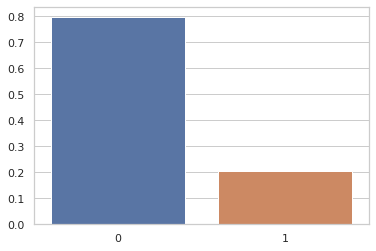

In [7]:
class_frequency = data.Exited.value_counts(normalize = True)
ax = sns.barplot(x= class_frequency.index, y = class_frequency.values)

Как мы видим, баланс классов сильно смещен - положительных значений только около 20%. Проверим, как поведет себя модель без учета этого дисбаланса - найдем значение метрики F1 и AUC-ROC. Но перед этим напишем функции для их вывода.

In [8]:
# функции получают на входе признаки и возвращают оценку метрик

def quick_f1(features, target):
    predicted = model.predict(features)
    f1 = f1_score(target, predicted)
    return f1

def quick_auc_roc(features, target):
    probabilities = model.predict_proba(features)
    probabilities_one = probabilities[:, 1]
    auc_roc = roc_auc_score(target, probabilities_one)
    return auc_roc

In [9]:
model = DecisionTreeClassifier(random_state=rnd_state)
model.fit(features_train, target_train)

print('Дерево решений. F1-мера без учета дисбаланса: {:.3f}'
      .format(quick_f1(features_valid, target_valid)))
print('Дерево решений. AUC-ROC без учета дисбаланса: {:.3f}'
      .format(quick_auc_roc(features_valid, target_valid)))
print()

model = RandomForestClassifier(random_state=rnd_state)
model.fit(features_train, target_train)

print('Случайный лес. F1-мера без учета дисбаланса: {:.3f}'
      .format(quick_f1(features_valid, target_valid)))
print('Случайный лес. AUC-ROC без учета дисбаланса: {:.3f}'
      .format(quick_auc_roc(features_valid, target_valid)))

Дерево решений. F1-мера без учета дисбаланса: 0.491
Дерево решений. AUC-ROC без учета дисбаланса: 0.681

Случайный лес. F1-мера без учета дисбаланса: 0.551
Случайный лес. AUC-ROC без учета дисбаланса: 0.821


Дерево решений показало метрику F1 равную 0.491. Случайный лес показал результат лучше, он равен 0.551.

Метрика AUC-ROC у случайного леса также выше.

Посмотрим, удастся ли улучшить результат, принимая во внимание дисбаланс классов.

# 3. Борьба с дисбалансом

Посмотрим, как изменится F1-мера при учитывания дисбаланса классов. Проверим изменение F1-меры при присваивании классам веса. Для этого в моделях укажем параметр `class_weight='balanced'`.

In [10]:
model = DecisionTreeClassifier(random_state=rnd_state, class_weight = 'balanced')
model.fit(features_train, target_train)

print('Присваивание веса классам.', '\n')
print('Дерево решений. F1-мера с учетом дисбаланса: {:.3f}'
      .format(quick_f1(features_valid, target_valid)))
print('Дерево решений. AUC-ROC с учетом дисбаланса: {:.3f}'
      .format(quick_auc_roc(features_valid, target_valid)))
print()

model = RandomForestClassifier(random_state=rnd_state, class_weight = 'balanced')
model.fit(features_train, target_train)

print('Случайный лес. F1-мера с учетом дисбаланса: {:.3f}'
      .format(quick_f1(features_valid, target_valid)))
print('Случайный лес. AUC-ROC с учетом дисбаланса: {:.3f}'
      .format(quick_auc_roc(features_valid, target_valid)))

Присваивание веса классам. 

Дерево решений. F1-мера с учетом дисбаланса: 0.476
Дерево решений. AUC-ROC с учетом дисбаланса: 0.671

Случайный лес. F1-мера с учетом дисбаланса: 0.560
Случайный лес. AUC-ROC с учетом дисбаланса: 0.826


Метрика F1 для дерева решений снизилась, а для слуайного леса немного выросла. При этом метрика AUC-ROC практически не изменилась. Пойдем дальше - используем технику `upsampling` для увеличения выборки редкого класса "1". Для это цели предварительно напишем функцию `upsample`. Так как в целевом признаке отношение классов 4:1, то увеличим выборку класса "1" в 4 раза, задав `repeat = 4`.

In [11]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rnd_state)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model = DecisionTreeClassifier(random_state=rnd_state)
model.fit(features_upsampled, target_upsampled)

print('Техника "upsampling".', '\n')
print('Дерево решений. F1-мера с учетом дисбаланса: {:.3f}'
      .format(quick_f1(features_valid, target_valid)))
print('Дерево решений. AUC-ROC с учетом дисбаланса: {:.3f}'
      .format(quick_auc_roc(features_valid, target_valid)))
print()

model = RandomForestClassifier(random_state=rnd_state)
model.fit(features_upsampled, target_upsampled)

print('Случайный лес. F1-мера с учетом дисбаланса: {:.3f}'
      .format(quick_f1(features_valid, target_valid)))
print('Случайный лес. AUC-ROC с учетом дисбаланса: {:.3f}'
      .format(quick_auc_roc(features_valid, target_valid)))

Техника "upsampling". 

Дерево решений. F1-мера с учетом дисбаланса: 0.471
Дерево решений. AUC-ROC с учетом дисбаланса: 0.666

Случайный лес. F1-мера с учетом дисбаланса: 0.585
Случайный лес. AUC-ROC с учетом дисбаланса: 0.825


При применении `upsampling` метрика AUC-ROC не изменилась. Случайный лес со стандартными гиперпараметрами при использовании `upsampling` выдал F1-меру равную 0.585 - рост меры очевиден. Проверим, как поведет себя модель при использовании техники `downsampling`: чтобы сбалансировать классы, возьмем 0.25 от класса "0".

In [12]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

model = DecisionTreeClassifier(random_state=rnd_state)
model.fit(features_downsampled, target_downsampled)

print('Техника "downsampling".', '\n')
print('Дерево решений. F1-мера с учетом дисбаланса: {:.3f}'
      .format(quick_f1(features_valid, target_valid)))
print('Дерево решений. AUC-ROC с учетом дисбаланса: {:.3f}'
      .format(quick_auc_roc(features_valid, target_valid)))
print()

model = RandomForestClassifier(random_state=rnd_state)
model.fit(features_downsampled, target_downsampled)

print('Случайный лес. F1-мера с учетом дисбаланса: {:.3f}'
      .format(quick_f1(features_valid, target_valid)))
print('Случайный лес. AUC-ROC с учетом дисбаланса: {:.3f}'
      .format(quick_auc_roc(features_valid, target_valid)))

Техника "downsampling". 

Дерево решений. F1-мера с учетом дисбаланса: 0.502
Дерево решений. AUC-ROC с учетом дисбаланса: 0.715

Случайный лес. F1-мера с учетом дисбаланса: 0.553
Случайный лес. AUC-ROC с учетом дисбаланса: 0.827


Техника `downsampling` показала себя лучше, чем `upsampling` на модели с деревом решений, но на случайном лесе результат хуже. Остановимся на технике `upsampling` и модели случайного леса.

Мы пока не трогали гиперпараметры модели. Попробуем улучшить метрики за счет их изменения.

In [13]:
lst = []
for estim in range(5, 155, 10):
    for depth in range(1, 31, 2):
        model = RandomForestClassifier(n_estimators=estim, max_depth = depth, random_state=rnd_state)
        model.fit(features_upsampled, target_upsampled)
        f1_rating = quick_f1(features_valid, target_valid)
        auc_roc_rating = quick_auc_roc(features_valid, target_valid)
        line = [estim, depth, f1_rating, auc_roc_rating]
        lst.append(line)
print_df = pd.DataFrame(lst, columns = ['Кол-во деревьев',
                                        'Глубина деревьев',
                                        'F1-мера',
                                        'AUC-ROC'])                                     

In [14]:
print_df.round(3).sort_values('F1-мера', ascending = False).head()

,Кол-во деревьев,Глубина деревьев,F1-мера,AUC-ROC
142,95,15,0.641,0.862
222,145,25,0.640,0.860
157,105,15,0.639,0.863
82,55,15,0.638,0.863
130,85,21,0.638,0.857


Лучший результат показали сразу три комбинации гиперпараметров у случайного леса. Проверим, как зависят значения F1-меры и AUC-ROC от количества деревьев и их глубины. Для этого построим тепловые карты соответствующих значений.

In [15]:
f1_heatmap = (print_df
              .pivot_table(index = 'Кол-во деревьев', columns = 'Глубина деревьев', values = 'F1-мера')
              .sort_values('Кол-во деревьев', ascending = False))
auc_roc_heatmap = (print_df
              .pivot_table(index = 'Кол-во деревьев', columns = 'Глубина деревьев', values = 'AUC-ROC')
              .sort_values('Кол-во деревьев', ascending = False))

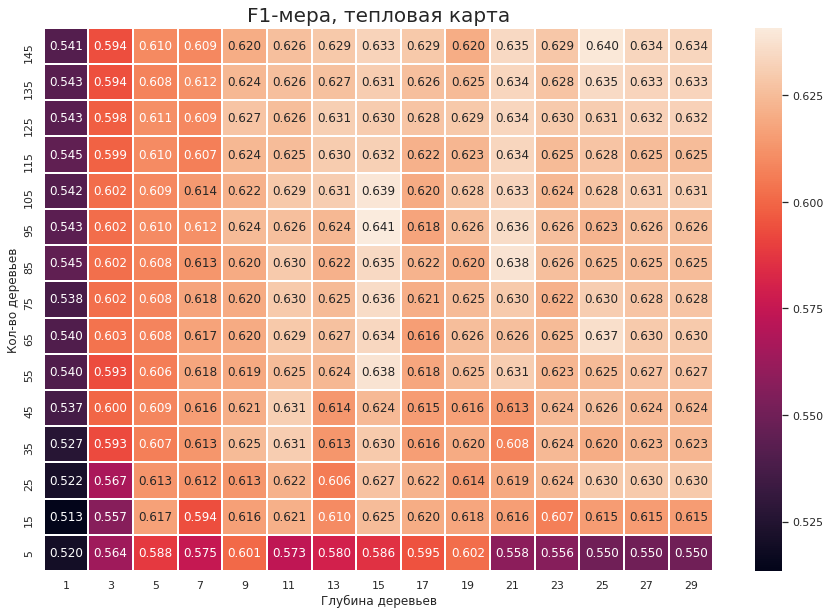

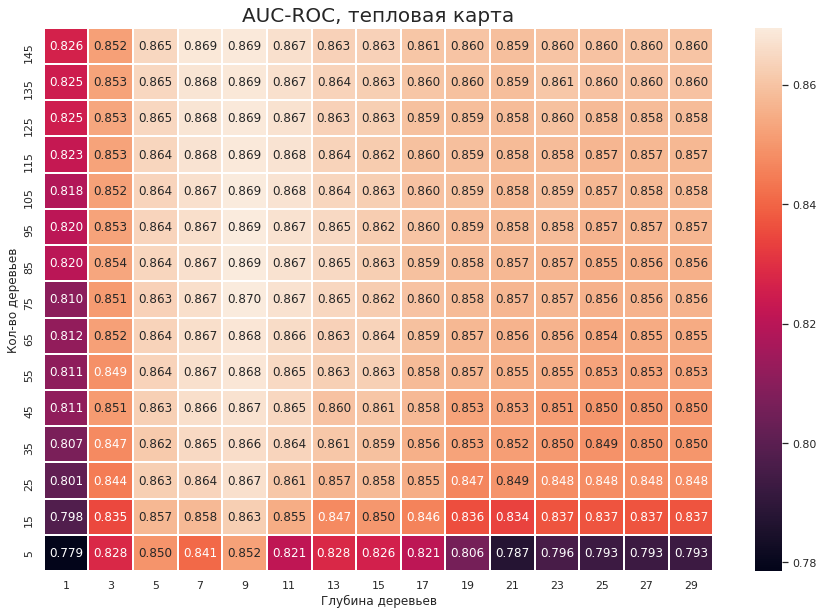

In [16]:
plt.figure(figsize=(15,10))
plt.title('F1-мера, тепловая карта', fontsize=20)
ax = sns.heatmap(f1_heatmap, annot=True, fmt='.3f', linewidths=1)
plt.show()
plt.figure(figsize=(15,10))
plt.title('AUC-ROC, тепловая карта', fontsize=20)
ax = sns.heatmap(auc_roc_heatmap, annot=True, fmt='.3f', linewidths=1)

F1-мера: по тепловой карте мы видим, что метрика низкая при малом количестве деревьев и при малой их глубине. Также можно заметить, что максимальные значения метрики достигаются при `depth = 13`, а количество деревьев не так важно (главное, чтобы их было больше 50-60). Также хорошие показатели метрики можно получить при использовании маленьких лесов (`estim = 15-25` и `depth = 15-17`) - выбор таких гиперпараметров может быть оправдан при работе с большими массивами данных, чтобы сэкономить время, затрачиваемое на построение модели.

AUC-ROC: максимальные значения достигаются при `depth = 9`, после этого они начинают падать. При этом количество деревьев на максимальное значение AUC-ROC влияет мало - при `estim >= 20` значения практически не меняются.
    
Из этого делаем вывод, что метрики ведут себя по разному: хотя на максимальное значение метрики сильнее влияет глубина дерева, для F1 лушим значением является `depth = 13`, а для AUC-ROC - `depth = 9`.

Остановимся на комбинации с максимальной F1-мерой при минимальном размере леса: количество деревьев 105, глубина деревьев 13. Проведем финальное тестирование с использованием этих гиперпараметров.

# 4. Тестирование модели

Для проведения финального тестирования сделаем `upsampling` для выборок `final_train`, в которой объединены обучающие и валидационные выборки. При обучении модели случайного леса выставим количество деревьев 105 и глубину дерева 13.

In [17]:
from sklearn.model_selection import GridSearchCV
model = RandomForestClassifier(random_state = rnd_state)
parameters = {'n_estimators': range(5, 155, 20),
              'max_depth': range(1, 31, 4)}
grid = GridSearchCV(model, parameters, scoring = 'f1')
grid.fit(features_upsampled, target_upsampled)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=702,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_g

In [18]:
features_upsampled, target_upsampled = upsample(features_final_train, target_final_train, 4)

model = RandomForestClassifier(n_estimators=105, max_depth=13, random_state=rnd_state)
model.fit(features_upsampled, target_upsampled)
print('Случайный лес (n_estim = 105, max_depth = 13). F1-мера: {:.3f}'
      .format(quick_f1(features_test, target_test)))

Случайный лес (n_estim = 105, max_depth = 13). F1-мера: 0.618


На тестовой выборке модель показала необходимый результат: F1-мера модели равна **0.618**. 

Напоследок построим и изучим график ROC-кривой, а также найдем значение AUC-ROC.

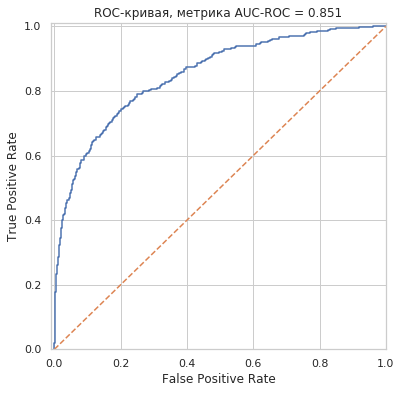

In [19]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(-0.01, 1)
plt.ylim(0, 1.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая, метрика AUC-ROC = {:.3f}'.format(auc_roc))
plt.show()

Из графика видно, что кривая находится заметно выше пунктирной линии, представляющей случайный классификатор, что говорит о качестве выбранной модели. Значение **0.851** для AUC-ROC это подтверждает, так как для идеальной модели `AUC-ROC = 1`.